# Align and remove blanks

Adapted from Giulia Vallardi's ImageJ macro, this notebook removes any blank frames from timelapse experiments and aligns the images. 

"Fiji macro to remove over- and under-exposed images, and align the image stacks

The settings for the alignments are: 
registration by Translation > only modify XY coordinates
Shrinkage constrain activated (this model allows a better registration based on all images, not using a reference image. It is more time consuming though)
Transform matrices are saved during registration and then applied to the other channels during transformation."

# to - do: decide how to import dask octopus

In [4]:
import octopuslite

ModuleNotFoundError: No module named 'octopuslite'

In [1]:
import os
import glob
import enum
import numpy as np
from pystackreg import StackReg
from skimage import io
from tqdm import tqdm
from daskoctopus import DaskOctopusLiteLoader
from skimage import transform as tf

# Find images, organise into raw folder and load using dask octo

In [2]:
### define root directory and specific experiment and location (will later make iterable)
root_dir = '/home/nathan/data/kraken/commitment/test/'
expt = "MK0003"
pos = "Pos1"

In [3]:
### create new subdir of for raw files and move them all there
if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw')):
    os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))
    files = sorted(glob.glob(os.path.join(root_dir, f'{expt}/{pos}/*.tif')))
    for file in files:
        os.rename(file, file.replace(f'{pos}', f'{pos}/{pos}_raw'))

In [4]:
### pre load files from raw file dir 
images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))

Using cropping: None


In [6]:
images['irfp']

dask.array<stack, shape=(1200, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

# Find blank or overexposed images and display average channel brightness

In [7]:
%%time
# pixel range criteria
max_pixel, min_pixel = 200, 2

### find mean values ### pre load files from raw file dir 
images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))

mean_arrays = {}
dodgy_frame_list = set([])
for channel in tqdm(images.channels):
    print(f'Finding mean values of {channel.name.lower()} images')
    mean_arrays[channel.name] = np.mean(images[channel.name], axis = (1,2)).compute() 
    for frame, mean_value in enumerate(mean_arrays[channel.name]):
        if max_pixel < mean_value or mean_value < min_pixel:
            dodgy_frame_list.add(frame)
dodgy_frame_list = list(dodgy_frame_list)

print('Number of under/over-exposed frames:', len(dodgy_frame_list))

Using cropping: None


  0%|          | 0/4 [00:00<?, ?it/s]

Finding mean values of brightfield images


 25%|██▌       | 1/4 [00:07<00:22,  7.36s/it]

Finding mean values of gfp images


 50%|█████     | 2/4 [00:13<00:13,  6.70s/it]

Finding mean values of rfp images


 75%|███████▌  | 3/4 [00:16<00:05,  5.11s/it]

Finding mean values of irfp images


100%|██████████| 4/4 [00:19<00:00,  4.96s/it]

Number of under/over-exposed frames: 8
CPU times: user 24.5 s, sys: 5.41 s, total: 29.9 s
Wall time: 20.6 s


# test removing dodgy frames from virtual stack

In [5]:
dodgy_frame_list = [1096, 617, 1003, 108, 972, 76, 783, 630]

In [8]:
dodgy_frame_list

[1096, 617, 1003, 108, 972, 76, 783, 630]

In [10]:
type(images['gfp'])

dask.array.core.Array

In [17]:
filtered_gfp = np.delete(images['gfp'], dodgy_frame_list, axis = 0)

In [18]:
filtered_gfp

dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

In [15]:
images['gfp']

dask.array<stack, shape=(1200, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

In [22]:
images['gfp'][76].compute()

array([[ 23,  53, 183, ...,   1,   2,   0],
       [  2,   0,   0, ...,   0,   0,   1],
       [  1,   0,   0, ...,   1,   0,   0],
       ...,
       [  0,   0,   0, ...,   1,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [23]:
filtered_gfp[76].compute()

array([[246, 129, 247, ...,  77,  72,  76],
       [ 81,  73,  78, ...,  79,  72,  77],
       [ 80,  74,  76, ...,  74,  72,  76],
       ...,
       [ 55,  55,  54, ...,  56,  56,  54],
       [ 56,  55,  55, ...,  57,  56,  55],
       [ 58,  57,  52, ...,  58,  54,  53]], dtype=uint8)

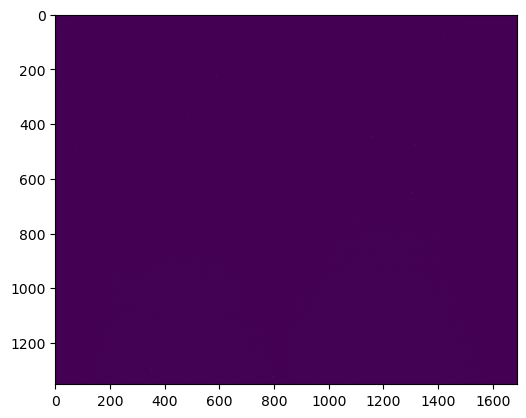

In [24]:
import matplotlib.pyplot as plt
plt.imshow(images['gfp'][76])
plt.show()

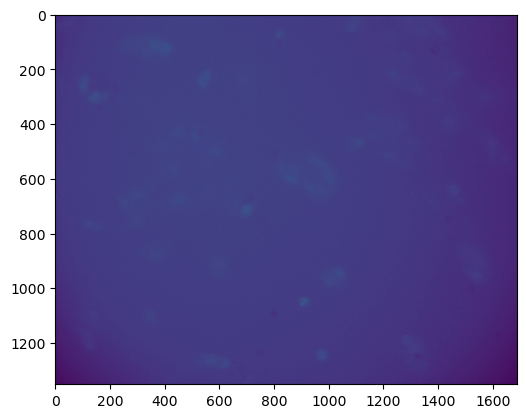

In [25]:
import matplotlib.pyplot as plt
plt.imshow(filtered_gfp[76])
plt.show()

# filtering method to remove blank or overexposed frames works on dask array

In [77]:
filtered_images= {}
for channel in images.channels:
    filtered_images[channel.name] = np.delete(images[channel], dodgy_frame_list, axis = 0)

In [78]:
filtered_images

{'BRIGHTFIELD': dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>,
 'GFP': dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>,
 'RFP': dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>,
 'IRFP': dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>}

In [37]:
filtered_images= {}
for channel in images.channels:
    images[channel.name] = np.delete(images[channel], dodgy_frame_list, axis = 0)

TypeError: 'DaskOctopusLiteLoader' object does not support item assignment

In [38]:
channel.name

'BRIGHTFIELD'

In [39]:
np.delete(images[channel], dodgy_frame_list, axis = 0)

dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

#### cant edit the original dask object, so i lose channel name compatability

Should I save out the files in new dir and reload them using dask? or can i create new octolite-like object that has similar properties like .name

In [41]:
import dask.array as da

In [47]:
###use delete from da
images['gfp'] = da.delete(images['gfp'], dodgy_frame_list, axis = 0)

TypeError: 'DaskOctopusLiteLoader' object does not support item assignment

In [65]:
images.files(channel.name)

['/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000000_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000001_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000002_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000003_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000004_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000005_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000006_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel003_position001_time000000007_z000.tif',
 '/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_chan

In [48]:
### try saving out --- with original indices? 

In [10]:
images.files('gfp')[1]

'/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000001_z000.tif'

In [11]:
for i in dodgy_frame_list:
    print(images.files('gfp')[i])

/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000001096_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000617_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000001003_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000108_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000972_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000076_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000783_z000.tif
/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_raw/img_channel001_position001_time000000630_z000.tif


### Either delete from directory? but then no raw copy

#### write out dask octo function to forget certain frames

### or write something to dask octo to delete from array???

# Delete from dask array stack and save out

In [21]:
images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))

Using cropping: None


In [22]:
dodgy_frame_list = [1096, 617, 1003, 108, 972, 76, 783, 630]

In [ ]:
filtered_images = {}
for channel in images.channels:
    print(channel)
    filtered_images[channel.name] = np.delete(images[channel.name], dodgy_frame_list, axis = 0)
    for i, image in tqdm(enumerate(filtered_images[channel.name])):
        fn = images.files(channel.name)[i].replace('_raw', '_filtered_aligned')
        io.imsave(fn, image, check_contrast=False)

Channels.BRIGHTFIELD


1192it [02:26,  8.14it/s]


Channels.GFP


1192it [02:18,  8.63it/s]


Channels.RFP


1192it [03:06,  6.39it/s]


Channels.IRFP


1092it [02:47,  2.97it/s]

In [ ]:
filtered_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_filtered_aligned'))

# Progressing ahead regardless of ^^

In [79]:
filtered_images['IRFP']

dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

In [ ]:
## remeasuring average channel intensity a

In [81]:
### filtering did work

In [80]:
%%time
# pixel range criteria
max_pixel, min_pixel = 200, 2

### find mean values ### pre load files from raw file dir 
images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))

mean_arrays = {}
dodgy_frame_list = set([])
for channel in tqdm(images.channels):
    print(f'Finding mean values of {channel.name.lower()} images')
    mean_arrays[channel.name] = np.mean(filtered_images[channel.name], axis = (1,2)).compute() 
### already calculated and used the below
    
#     for frame, mean_value in enumerate(mean_arrays[channel.name]):
#         if max_pixel < mean_value or mean_value < min_pixel:
#             dodgy_frame_list.add(frame)
# dodgy_frame_list = list(dodgy_frame_list)

# print('Number of under/over-exposed frames:', len(dodgy_frame_list))

Using cropping: None


  0%|          | 0/4 [00:00<?, ?it/s]

Finding mean values of brightfield images


 25%|██▌       | 1/4 [00:03<00:10,  3.54s/it]

Finding mean values of gfp images


 50%|█████     | 2/4 [00:06<00:06,  3.26s/it]

Finding mean values of rfp images


 75%|███████▌  | 3/4 [00:09<00:03,  3.24s/it]

Finding mean values of irfp images


100%|██████████| 4/4 [00:12<00:00,  3.23s/it]

Number of under/over-exposed frames: 0
CPU times: user 27.4 s, sys: 5.21 s, total: 32.6 s
Wall time: 13.5 s


# Select reference image to base alignment around

In [82]:
print('Average channel brightness for selection of reference image:')
for channel in images.channels:
    print(f'{channel.value}: {channel.name}:', np.mean(mean_arrays[channel.name]))

Average channel brightness for selection of reference image:
0: BRIGHTFIELD: 28.574265
1: GFP: 62.654087
2: RFP: 6.0335283
3: IRFP: 76.07041


In [86]:
 filtered_images['IRFP']

dask.array<concatenate, shape=(1192, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

In [87]:
# manually select reference channel by adding index
# reference_channel = filtered_images['IRFP']
# automatically select reference channel from max average pixel value (ie. brightest channel)
#reference_channel = images.channels[max([(channel.value, np.mean(mean_arrays[channel.name])) for channel in images.channels])[0]]
reference_image = filtered_images['IRFP']


In [40]:
images['gfp']

dask.array<stack, shape=(1200, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

## Set cropped area of reference image to base alignment around (whole image struggles to compute)

In [88]:
crop_area = 500
reference_image = reference_image[:,int((reference_image.shape[2]-crop_area)/2):int(reference_image.shape[2]-(reference_image.shape[2]-crop_area)/2),int((reference_image.shape[1]-crop_area)/2):int(reference_image.shape[1]-(reference_image.shape[1]-crop_area)/2)].compute()
reference_image.shape

(1192, 500, 500)

# Register alignment and save out

In [90]:
%%time
# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 

# register each frame to the previous as transformation matrices/tensor
transform_tensor = sr.register_stack(reference_image, reference = 'previous').astype(np.int8)

# save out transform tensor
np.save(os.path.join(root_dir, f'{expt}/{pos}/filtered_irfp_transform_tensor.npy'), transform_tensor)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


CPU times: user 2min 30s, sys: 3.79 s, total: 2min 34s
Wall time: 2min 34s


In [91]:
transform_tensor.shape

(1192, 3, 3)

# Apply transformation matrix to all channels and save out images

In [92]:
%%time
### iterating over channels
# create aligned image dir if does not exist 
if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_filtered_aligned')):
    os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_filtered_aligned'))
# iterate over channels
for channel in images.channels:
    print('Aligning', channel.name.lower(), 'channel', channel.value+1, '/', len(images.channels))
    #iterate over all images in channel
    for i in tqdm(range(len(filtered_images[channel.name]))):
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],rotation = None)
        # transform image
        transformed_image = (tf.warp(filtered_images[channel.name][i,...], transform_matrix)*255).astype(np.uint8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_raw', '_filtered_aligned')
        # save trans image out
        io.imsave(fn, transformed_image, check_contrast=False)

Aligning brightfield channel 1 / 4


100%|██████████| 1192/1192 [01:26<00:00, 13.72it/s]


Aligning gfp channel 2 / 4


100%|██████████| 1192/1192 [01:25<00:00, 13.97it/s]


Aligning rfp channel 3 / 4


100%|██████████| 1192/1192 [01:25<00:00, 13.98it/s]


Aligning irfp channel 4 / 4


100%|██████████| 1192/1192 [01:27<00:00, 13.59it/s]

CPU times: user 5min 35s, sys: 12.4 s, total: 5min 47s
Wall time: 5min 45s


# Select reference image to base alignment around

In [82]:
print('Average channel brightness for selection of reference image:')
for channel in images.channels:
    print(f'{channel.value}: {channel.name}:', np.mean(mean_arrays[channel.name]))

Average channel brightness for selection of reference image:
0: BRIGHTFIELD: 28.574265
1: GFP: 62.654087
2: RFP: 6.0335283
3: IRFP: 76.07041


In [83]:
# manually select reference channel by adding index
reference_channel = images.channels[3]
# automatically select reference channel from max average pixel value (ie. brightest channel)
#reference_channel = images.channels[max([(channel.value, np.mean(mean_arrays[channel.name])) for channel in images.channels])[0]]
reference_image = images[reference_channel.name]
reference_channel.name

'IRFP'

In [40]:
images['gfp']

dask.array<stack, shape=(1200, 1352, 1688), dtype=float32, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

## Set cropped area of reference image to base alignment around (whole image struggles to compute)

In [31]:
crop_area = 500
reference_image = reference_image[:,int((reference_image.shape[2]-crop_area)/2):int(reference_image.shape[2]-(reference_image.shape[2]-crop_area)/2),int((reference_image.shape[1]-crop_area)/2):int(reference_image.shape[1]-(reference_image.shape[1]-crop_area)/2)].compute()
reference_image.shape

(1200, 500, 500)

# Register alignment and save out

In [9]:
reference_image = reference_image.compute()

In [10]:
%%time
# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 

# register each frame to the previous as transformation matrices/tensor
transform_tensor = sr.register_stack(reference_image, reference = 'previous').astype(np.int8)

# save out transform tensor
np.save(os.path.join(root_dir, f'{expt}/{pos}/{reference_channel.name.lower()}_transform_tensor.npy'), transform_tensor)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 1 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


CPU times: user 23min 39s, sys: 2min 19s, total: 25min 58s
Wall time: 25min 56s


In [60]:
transform_tensor.shape

(1199, 3, 3)

# Apply transformation matrix to all channels and save out images

In [12]:
%%time
### iterating over channels
# create aligned image dir if does not exist 
if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned')):
    os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))
# iterate over channels
for channel in images.channels:
    print('Aligning', channel.name.lower(), 'channel', channel.value+1, '/', len(images.channels))
    #iterate over all images in channel
    for i in tqdm(range(len(images[channel.name]))):
        # skip dodgy frames and don't save out into aligned folder
        if i in dodgy_frame_list:
            continue
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],rotation = None)
        # transform image
        transformed_image = (tf.warp(images[channel.name][i,...], transform_matrix)*255).astype(np.uint8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_raw', '_aligned')
        # save trans image out
        io.imsave(fn, transformed_image, check_contrast=False)

Aligning brightfield channel 1 / 4


100%|██████████| 1200/1200 [02:27<00:00,  8.12it/s]


Aligning gfp channel 2 / 4


100%|██████████| 1200/1200 [02:21<00:00,  8.51it/s]


Aligning rfp channel 3 / 4


100%|██████████| 1200/1200 [02:19<00:00,  8.59it/s]


Aligning irfp channel 4 / 4


100%|██████████| 1200/1200 [02:23<00:00,  8.35it/s]

CPU times: user 6min 26s, sys: 16.4 s, total: 6min 43s
Wall time: 9min 32s


In [96]:
aligned_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_filtered_aligned'))
old_aligned_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))
viewer = napari.Viewer()
for channel in aligned_images.channels:
    viewer.add_image(aligned_images[channel.name], name = channel.name, blending = 'additive', contrast_limits = [0,255])
    #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps
    viewer.add_image(images[channel.name], name = channel.name+'raw', blending = 'additive', contrast_limits = [0,255])
                     #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps
    viewer.add_image(old_aligned_images[channel.name], name = channel.name+'old', blending = 'additive', contrast_limits = [0,255])
                     #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps

Using cropping: None
Using cropping: None


In [97]:
viewer = napari.Viewer()
viewer.add_image(aligned_images['IRFP'], name = channel.name+'new', blending = 'additive', contrast_limits = [0,255])
#, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps
viewer.add_image(images['IRFP'], name = channel.name+'raw', blending = 'additive', contrast_limits = [0,255])
                 #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps
viewer.add_image(old_aligned_images['IRFP'], name = channel.name+'old', blending = 'additive', contrast_limits = [0,255])
                 #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps

<Image layer 'IRFPold' at 0x7ff884040d60>

In [98]:
# what is happening at frame 1183??
transform_tensor[1183]

array([[   1,    0,  -34],
       [   0,    1, -128],
       [   0,    0,    1]], dtype=int8)

# Troubleshooting jumpy transforms

In [54]:
### problematic frame
i = 47

In [55]:
### significant longitudinal shift at frame 1
transform_tensor[i,...]

array([[  1,   0, -21],
       [  0,   1, -98],
       [  0,   0,   1]], dtype=int8)

In [60]:
### another lateral shift at frame 6
transform_tensor[i-1,...]

array([[ 1,  0, 19],
       [ 0,  1, -4],
       [ 0,  0,  1]], dtype=int8)

In [18]:
### finding maximum shift

In [35]:
np.amax(transform_tensor)

127

In [33]:
### theres a lot of frames with this max shift
for i in range(len(transform_tensor)):
    if np.amax(transform_tensor[i,...]) == 127:
        print(i)

307
391
392
393
395
396
398
399
401
415
418
420
515
530
538
539
540
541
542
580
593
613
626
627
628
631
632
633
634
635
637
642
643
644
645
647
648
650
651
652
653
654
655
656
657
658
659
660
665
666
667
702
728
738
743
753
756


# Trying different methods of transformation alignment

In [39]:
images['gfp'][47]

dask.array<getitem, shape=(1352, 1688), dtype=float32, chunksize=(1352, 1688), chunktype=numpy.ndarray>

In [ ]:
### single image

In [40]:
images['gfp'][47].compute()

array([[157,  29,  25, ...,  70,  69,  68],
       [ 73,  73,  72, ...,  70,  67,  68],
       [ 73,  74,  70, ...,  67,  68,  67],
       ...,
       [ 51,  54,  52, ...,  52,  52,  54],
       [ 53,  53,  54, ...,  50,  52,  54],
       [ 54,  52,  51, ...,  51,  51,  53]], dtype=uint8)

In [45]:
i = 47

In [46]:
out_tra = sr.register(images['gfp'][i-1], images['gfp'][i])

In [47]:
out_tra

array([[  1.        ,   0.        , -40.72189378],
       [  0.        ,   1.        , -93.97357383],
       [  0.        ,   0.        ,   1.        ]])

In [48]:
out_tra.astype(np.int8)

array([[  1,   0, -40],
       [  0,   1, -93],
       [  0,   0,   1]], dtype=int8)

# Try different transformation methods

In [ ]:
# transformation matrix should take on the form

#             [1 , 0 , x
#              0 , 1 , y
#              0 , 0 , 1]

# where x and y are the translate magnitudes

In [63]:
i = 47

In [64]:
### float translation
StackReg(StackReg.TRANSLATION).register(images['gfp'][i-1], images['gfp'][i])

array([[  1.        ,   0.        , -40.72189378],
       [  0.        ,   1.        , -93.97357383],
       [  0.        ,   0.        ,   1.        ]])

In [75]:
### int translation
StackReg(StackReg.TRANSLATION).register(images['gfp'][i-1], images['gfp'][i]).astype(np.int8)

array([[  1,   0, -40],
       [  0,   1, -93],
       [  0,   0,   1]], dtype=int8)

In [66]:
### float rigid body
StackReg(StackReg.RIGID_BODY).register(images['gfp'][i-1], images['gfp'][i])

array([[ 9.99997919e-01,  2.04021154e-03, -3.24573990e+01],
       [-2.04021154e-03,  9.99997919e-01, -6.02019623e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [76]:
### np.rint rigid body
np.rint(StackReg(StackReg.RIGID_BODY).register(images['gfp'][i-1], images['gfp'][i]))

array([[  1.,   0., -32.],
       [ -0.,   1., -60.],
       [  0.,   0.,   1.]])

In [67]:
### integer-ising the matrix zeroes some important numbers

In [70]:
### int rigidbody
StackReg(StackReg.RIGID_BODY).register(images['gfp'][i-1], images['gfp'][i]).astype(np.int8)

array([[ 0,  0, 53],
       [ 0,  0, 49],
       [ 0,  0,  1]], dtype=int8)

In [71]:
### float affine
StackReg(StackReg.AFFINE).register(images['gfp'][i-1], images['gfp'][i])

array([[ 8.85810604e-01, -1.31468704e-02,  5.37588333e+01],
       [-8.63918693e-03,  8.96640838e-01,  4.93034402e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [77]:
### np.rint rigid body
np.rint(StackReg(StackReg.AFFINE).register(images['gfp'][i-1], images['gfp'][i]))

array([[ 1., -0., 54.],
       [-0.,  1., 49.],
       [ 0.,  0.,  1.]])

In [72]:
### int affine
StackReg(StackReg.AFFINE).register(images['gfp'][i-1], images['gfp'][i]).astype(np.int8)

array([[ 0,  0, 53],
       [ 0,  0, 49],
       [ 0,  0,  1]], dtype=int8)

# seems like all the alignment methods produce similar shifted outputs... is it the images?

In [79]:
for channel in images.channels:
    print(channel.name, StackReg(StackReg.TRANSLATION).register(images[channel.name][i-1], images[channel.name][i]).astype(np.int8))

BRIGHTFIELD [[ 1  0 -6]
 [ 0  1  0]
 [ 0  0  1]]
GFP [[  1   0 -40]
 [  0   1 -93]
 [  0   0   1]]
RFP [[ 1  0 -5]
 [ 0  1 -1]
 [ 0  0  1]]
IRFP [[ 1  0 -5]
 [ 0  1  0]
 [ 0  0  1]]


# is it the gfp channel? checking each channel for max transformation

In [5]:
trans_tensors = {}
for channel in images.channels:
    print('Starting channel:', channel.name)
    trans_tensor = []
    for i in tqdm(range(1, len(images['gfp']))):
        ### create transformation matrix for i'th and i+1'th frame
        trans_matrix = StackReg(StackReg.TRANSLATION).register(images[channel.name][i-1], images[channel.name][i]).astype(np.int8)
        trans_tensor.append(trans_matrix)
    trans_tensor = np.stack(trans_tensor)
    trans_tensors[channel.name] = trans_tensor
    print(channel.name, np.amax(trans_tensor))

Starting channel: BRIGHTFIELD


100%|██████████| 1199/1199 [25:51<00:00,  1.29s/it]


BRIGHTFIELD 126
Starting channel: GFP


100%|██████████| 1199/1199 [26:16<00:00,  1.31s/it]


GFP 108
Starting channel: RFP


100%|██████████| 1199/1199 [27:56<00:00,  1.40s/it]


RFP 47
Starting channel: IRFP


100%|██████████| 1199/1199 [27:06<00:00,  1.36s/it]

IRFP 24


In [6]:
import pickle
with open('all_ch_trans_tensors.json', 'wb') as fp:
    pickle.dump(trans_tensors, fp)

# Checking the alignment tensors of each channel

In [10]:
for channel in trans_tensors:
    print(channel, np.amax(trans_tensors[channel]))

BRIGHTFIELD 126
GFP 108
RFP 47
IRFP 24


# irfp channel has lowest max shift in so test run alignment on that 

In [15]:
transform_tensor = trans_tensors['IRFP']

In [16]:
np.amax(transform_tensor)

24

In [23]:
len(images['gfp']), len(transform_tensor)

(1200, 1199)

In [26]:
%%time

for channel in images.channels:
    print('Aligning', channel.name.lower(), 'channel', channel.value+1, '/', len(images.channels))
    #iterate over all images in channel
    for i in tqdm(range(len(images[channel.name]))):
        # skip dodgy frames and don't save out into aligned folder
        if i in dodgy_frame_list or i == 1199:
            continue
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],rotation = None)
        # transform image
        transformed_image = (tf.warp(images[channel.name][i,...], transform_matrix)*255).astype(np.uint8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_raw', '_aligned')
        # save trans image out
        io.imsave(fn, transformed_image, check_contrast=False)

Aligning brightfield channel 1 / 4


100%|██████████| 1200/1200 [01:28<00:00, 13.62it/s]


Aligning gfp channel 2 / 4


100%|██████████| 1200/1200 [01:28<00:00, 13.62it/s]


Aligning rfp channel 3 / 4


100%|██████████| 1200/1200 [01:26<00:00, 13.92it/s]


Aligning irfp channel 4 / 4


100%|██████████| 1200/1200 [01:31<00:00, 13.06it/s]

CPU times: user 5min 11s, sys: 43.9 s, total: 5min 55s
Wall time: 5min 54s


# is it saving out the image as unsigned?

In [27]:
%%time

for channel in images.channels:
    print('Aligning', channel.name.lower(), 'channel', channel.value+1, '/', len(images.channels))
    #iterate over all images in channel
    for i in tqdm(range(1, len(images[channel.name]))):
        # skip dodgy frames and don't save out into aligned folder
        if i in dodgy_frame_list or i == 1199:
            continue
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],rotation = None)
        # transform image
        transformed_image = (tf.warp(images[channel.name][i,...], transform_matrix)*255).astype(np.int8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_raw', '_aligned_signed')
        # save trans image out
        io.imsave(fn, transformed_image, check_contrast=False)

Aligning brightfield channel 1 / 4


100%|██████████| 1199/1199 [01:30<00:00, 13.31it/s]


Aligning gfp channel 2 / 4


100%|██████████| 1199/1199 [01:41<00:00, 11.76it/s]


Aligning rfp channel 3 / 4


100%|██████████| 1199/1199 [02:09<00:00,  9.27it/s]


Aligning irfp channel 4 / 4


100%|██████████| 1199/1199 [02:08<00:00,  9.30it/s]

CPU times: user 5min 26s, sys: 45.6 s, total: 6min 12s
Wall time: 7min 30s


# inspecting particular shift at frame 1087-1088, manually looks to be about 10 pixels to the left

In [37]:
### load transform tensors for each channel
transform_tensors = np.load('all_ch_trans_tensors.json', allow_pickle=True)

In [49]:
for i in range(1086, 1090):
    print(i)
    for channel in transform_tensors:
        print(channel)
        print(transform_tensors[channel][i])

#     print(channel, 1084, transform_tensors[channel][1084])
#     print(channel, 1085, transform_tensors[channel][1085])
#     print(channel, 1086, transform_tensors[channel][1086])
#     print(channel, 1087, transform_tensors[channel][1087])
#     print(channel, 1088, transform_tensors[channel][1088])

1086
BRIGHTFIELD
[[ 1  0 43]
 [ 0  1 28]
 [ 0  0  1]]
GFP
[[1 0 2]
 [0 1 0]
 [0 0 1]]
RFP
[[1 0 2]
 [0 1 0]
 [0 0 1]]
IRFP
[[1 0 2]
 [0 1 0]
 [0 0 1]]
1087
BRIGHTFIELD
[[ 1  0 -9]
 [ 0  1  0]
 [ 0  0  1]]
GFP
[[ 1  0 -9]
 [ 0  1 -1]
 [ 0  0  1]]
RFP
[[ 1  0 -9]
 [ 0  1  0]
 [ 0  0  1]]
IRFP
[[ 1  0 -9]
 [ 0  1 -1]
 [ 0  0  1]]
1088
BRIGHTFIELD
[[ 1  0 46]
 [ 0  1 18]
 [ 0  0  1]]
GFP
[[1 0 4]
 [0 1 0]
 [0 0 1]]
RFP
[[1 0 4]
 [0 1 0]
 [0 0 1]]
IRFP
[[1 0 4]
 [0 1 0]
 [0 0 1]]
1089
BRIGHTFIELD
[[ 1  0 -4]
 [ 0  1  0]
 [ 0  0  1]]
GFP
[[ 1  0 -4]
 [ 0  1  0]
 [ 0  0  1]]
RFP
[[ 1  0 -4]
 [ 0  1 -1]
 [ 0  0  1]]
IRFP
[[ 1  0 -4]
 [ 0  1  0]
 [ 0  0  1]]


# inspecting irfp tensor

In [56]:
[(i, np.amax(trans_tensors['IRFP'][i])) for i in range(len(trans_tensors['IRFP']))]

[(0, 5),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 1),
 (10, 1),
 (11, 7),
 (12, 1),
 (13, 5),
 (14, 1),
 (15, 1),
 (16, 5),
 (17, 1),
 (18, 3),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 9),
 (27, 1),
 (28, 1),
 (29, 13),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 6),
 (34, 1),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 6),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 4),
 (53, 1),
 (54, 12),
 (55, 1),
 (56, 1),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 5),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 2),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 2),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 2),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 4),
 (96, 1),
 (97, 1),
 (98, 5),
 (99, 1),
 (100, 1

In [59]:
for n, i in enumerate(trans_tensors['IRFP']):
    print(n, i)

0 [[1 0 5]
 [0 1 0]
 [0 0 1]]
1 [[ 1  0 -2]
 [ 0  1  0]
 [ 0  0  1]]
2 [[1 0 0]
 [0 1 0]
 [0 0 1]]
3 [[1 0 0]
 [0 1 0]
 [0 0 1]]
4 [[1 0 0]
 [0 1 0]
 [0 0 1]]
5 [[1 0 0]
 [0 1 0]
 [0 0 1]]
6 [[1 0 0]
 [0 1 0]
 [0 0 1]]
7 [[1 0 0]
 [0 1 0]
 [0 0 1]]
8 [[1 0 2]
 [0 1 2]
 [0 0 1]]
9 [[ 1  0 -6]
 [ 0  1  0]
 [ 0  0  1]]
10 [[1 0 0]
 [0 1 0]
 [0 0 1]]
11 [[1 0 7]
 [0 1 1]
 [0 0 1]]
12 [[1 0 0]
 [0 1 0]
 [0 0 1]]
13 [[1 0 5]
 [0 1 2]
 [0 0 1]]
14 [[1 0 0]
 [0 1 0]
 [0 0 1]]
15 [[ 1  0 -3]
 [ 0  1 -1]
 [ 0  0  1]]
16 [[1 0 5]
 [0 1 0]
 [0 0 1]]
17 [[1 0 0]
 [0 1 0]
 [0 0 1]]
18 [[1 0 3]
 [0 1 0]
 [0 0 1]]
19 [[1 0 0]
 [0 1 0]
 [0 0 1]]
20 [[1 0 0]
 [0 1 0]
 [0 0 1]]
21 [[ 1  0 -3]
 [ 0  1 -1]
 [ 0  0  1]]
22 [[1 0 0]
 [0 1 0]
 [0 0 1]]
23 [[1 0 0]
 [0 1 0]
 [0 0 1]]
24 [[1 0 0]
 [0 1 0]
 [0 0 1]]
25 [[1 0 0]
 [0 1 0]
 [0 0 1]]
26 [[1 0 9]
 [0 1 0]
 [0 0 1]]
27 [[ 1  0 -2]
 [ 0  1 -1]
 [ 0  0  1]]
28 [[ 1  0 -4]
 [ 0  1 -1]
 [ 0  0  1]]
29 [[ 1  0 13]
 [ 0  1  2]
 [ 0  0  1]]
30 [[ 1  0 -4]
 [

648 [[ 1  0 -7]
 [ 0  1 -1]
 [ 0  0  1]]
649 [[1 0 4]
 [0 1 0]
 [0 0 1]]
650 [[ 1  0 -5]
 [ 0  1  0]
 [ 0  0  1]]
651 [[1 0 2]
 [0 1 0]
 [0 0 1]]
652 [[1 0 0]
 [0 1 0]
 [0 0 1]]
653 [[1 0 0]
 [0 1 0]
 [0 0 1]]
654 [[1 0 0]
 [0 1 0]
 [0 0 1]]
655 [[1 0 0]
 [0 1 0]
 [0 0 1]]
656 [[1 0 0]
 [0 1 0]
 [0 0 1]]
657 [[1 0 0]
 [0 1 0]
 [0 0 1]]
658 [[ 1  0 -6]
 [ 0  1 -1]
 [ 0  0  1]]
659 [[1 0 0]
 [0 1 0]
 [0 0 1]]
660 [[1 0 0]
 [0 1 0]
 [0 0 1]]
661 [[1 0 0]
 [0 1 0]
 [0 0 1]]
662 [[1 0 0]
 [0 1 0]
 [0 0 1]]
663 [[1 0 0]
 [0 1 0]
 [0 0 1]]
664 [[1 0 0]
 [0 1 0]
 [0 0 1]]
665 [[1 0 0]
 [0 1 0]
 [0 0 1]]
666 [[1 0 0]
 [0 1 0]
 [0 0 1]]
667 [[ 1  0 -2]
 [ 0  1  0]
 [ 0  0  1]]
668 [[1 0 3]
 [0 1 0]
 [0 0 1]]
669 [[ 1  0 -6]
 [ 0  1  0]
 [ 0  0  1]]
670 [[ 1  0 -2]
 [ 0  1  0]
 [ 0  0  1]]
671 [[1 0 5]
 [0 1 0]
 [0 0 1]]
672 [[1 0 0]
 [0 1 0]
 [0 0 1]]
673 [[1 0 0]
 [0 1 0]
 [0 0 1]]
674 [[1 0 0]
 [0 1 0]
 [0 0 1]]
675 [[1 0 0]
 [0 1 0]
 [0 0 1]]
676 [[1 0 3]
 [0 1 0]
 [0 0 1]]
677 [[ 1  0 -3]
 [

 [ 0  0  1]]
1189 [[1 0 0]
 [0 1 0]
 [0 0 1]]
1190 [[1 0 0]
 [0 1 0]
 [0 0 1]]
1191 [[ 1  0 -2]
 [ 0  1  0]
 [ 0  0  1]]
1192 [[ 1  0 -1]
 [ 0  1  0]
 [ 0  0  1]]
1193 [[1 0 3]
 [0 1 0]
 [0 0 1]]
1194 [[1 0 1]
 [0 1 0]
 [0 0 1]]
1195 [[ 1  0 -2]
 [ 0  1  0]
 [ 0  0  1]]
1196 [[1 0 0]
 [0 1 0]
 [0 0 1]]
1197 [[1 0 0]
 [0 1 0]
 [0 0 1]]
1198 [[1 0 0]
 [0 1 0]
 [0 0 1]]


# Print dodgy frame list as a part of troubleshooting

In [30]:
print(sorted(dodgy_frame_list))

[76, 108, 617, 630, 783, 972, 1003, 1096]


# Check alignment using Napari

In [28]:
import napari

In [33]:
aligned_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))

viewer = napari.Viewer()
for channel in aligned_images.channels:
    viewer.add_image(aligned_images[channel.name], name = channel.name, blending = 'additive', contrast_limits = [0,255])
    #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps
    viewer.add_image(images[channel.name], name = channel.name+'raw', blending = 'additive', contrast_limits = [0,255])
                     #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps

Using cropping: None


In [30]:
aligned_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned_signed'))

viewer = napari.Viewer()
viewer.add_image(images['gfp'], name = 'gfp', blending = 'additive', contrast_limits = [0,255])
                     #, colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps

Using cropping: None


<Image layer 'gfp' at 0x7fe2c7a379d0>

# Batch execute

In [1]:
root_dir = '/home/nathan/data/kraken/commitment/test/'


In [ ]:
%%time
alignment(expt_list = ['MK0000', 'MK0001', 'MK0002', 'MK0003'], 
          max_pixel = 200, 
          min_pixel = 2, 
          crop_area = 500)

In [ ]:
viewer = napari.Viewer()
for channel in aligned_images.channels:
    viewer.add_image(aligned_images[channel.name], name = channel.name, blending = 'additive', contrast_limits = [0,255], colormap = napari.utils.colormaps.SIMPLE_COLORMAPS.popitem()) # lazy hack to randomly generate different colormaps

In [5]:
def alignment(expt_list, max_pixel, min_pixel, crop_area):

    ### Iterate over all experiments defined in expt_list
    for expt in expt_list:
        # Find all positions in that experiment
        pos_list = [pos for pos in os.listdir(os.path.join(root_dir, expt)) if 'Pos' in pos]
        ### Iterate over all positions in that experiment
        for pos in pos_list:
            ### create new subdir of for raw files and move them all there
            if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw')):
                os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))
                files = sorted(glob.glob(os.path.join(root_dir, f'{expt}/{pos}/*.tif')))
                for file in files:
                    os.rename(file, file.replace(f'{pos}', f'{pos}/{pos}_raw'))

            ### pre load files from raw file dir 
            images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_raw'))

            ### measure mean pixel value arrays and use to find under/over-exposed frames
            # create empty dicts and sets to store values in 
            mean_arrays = {}
            dodgy_frame_list = set([])
            # iterate over channels
            for channel in tqdm(images.channels):
                print(f'Finding mean values of {channel.name.lower()} images', pos, expt)
                # find mean pixel values for each channel
                mean_arrays[channel.name] = np.mean(images[channel.name], axis = (1,2)).compute() 
                # iterate over frames
                for frame, mean_value in enumerate(mean_arrays[channel.name]):
                    if max_pixel < mean_value or mean_value < min_pixel:
                        # if frame does not meet inclusion criteria then add to dodgy list
                        dodgy_frame_list.add(frame)
            dodgy_frame_list = list(dodgy_frame_list)
            print('Number of under/over-exposed frames:', len(dodgy_frame_list), pos, expt)

            ### create aligned image dir if does not exist 
            if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned')):
                os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))

            ### Automatically pick reference image to perform alignment on 
            # Pick channel based on index of brightest channel from maximum mean pixel array
            reference_channel = images.channels[max([(channel.value, np.mean(mean_arrays[channel.name])) for channel in images.channels])[0]]
            # Define reference images
            reference_image = images[reference_channel.name]
            reference_image = reference_image[:,int((reference_image.shape[2]-crop_area)/2):int(reference_image.shape[2]-(reference_image.shape[2]-crop_area)/2),int((reference_image.shape[1]-crop_area)/2):int(reference_image.shape[1]-(reference_image.shape[1]-crop_area)/2)].compute()
            reference_image.shape
            print('Automatically selected and cropped reference image:', reference_channel.name)

            ### Register alignment
            print('Registering alignment for', pos, expt)
            # create operator using transformation type (translation)
            sr = StackReg(StackReg.TRANSLATION) 
            # register each frame using reference image to the previous as transformation matrices/tensor
            transform_tensor = sr.register_stack(reference_image, reference = 'previous').astype(np.uint8)
            # save out transform tensor
            np.save(os.path.join(root_dir, f'{expt}/{pos}/{reference_channel.name.lower()}_transform_tensor.npy'), transform_tensor)

            ### Perform alignment
            # create aligned image dir if does not exist 
            if not os.path.exists(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned')):
                os.mkdir(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))
            # iterate over channels
            for channel in images.channels:
                print('Aligning', channel.name.lower(), 'channel', channel.value+1, '/', len(images.channels))
                #iterate over all images in channel
                for i in tqdm(range(len(images[channel.name]))):
                    # skip dodgy frames and don't save out into aligned folder
                    if i in dodgy_frame_list:
                        continue
                    # load specific transform matrix for that frame
                    transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],rotation = None)
                    # transform image
                    transformed_image = (tf.warp(images[channel.name][i,...], transform_matrix)*255).astype(np.uint8)
                    # set transformed image pathname by editing base dir
                    fn = images.files(channel.name)[i].replace('_raw', '_aligned')
                    # save trans image out
                    io.imsave(fn, transformed_image, check_contrast=False)

# Repeat alignment for larger datasets

# Compile stacks and save out?

In [ ]:
start()
aligned_images = DaskOctopusLiteLoader(os.path.join(root_dir, f'{expt}/{pos}/{pos}_aligned'))
stop()